In [1]:
!pip install binance_historical_data mplfinance stable-baselines3 backtesting tensorboard binance ta scikit-learn
# !pip install line_profiler


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
#!git clone https://github.com/Klok-e/python-price-predict-experiment.git

import sys

sys.path.insert(0, 'python-price-predict-experiment')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# 
# import time
# import os
# try:
#   os.makedirs("./drive/MyDrive/colab/computed-data/")
# except:
#   pass

In [5]:
from util import download_and_process_data_if_available

df_tickers = download_and_process_data_if_available("cache/df_tickers.pkl")

Loading data from cache


In [15]:
import pandas as pd

df = pd.read_csv("Literature_Named_PPO_Hyperparameters.csv")
df.to_latex(escape=False)

'\\begin{tabular}{llr}\n\\toprule\n & Parameter & Value \\\\\n\\midrule\n0 & Learning Rate (α) & 0.000300 \\\\\n1 & Discount Factor (γ) & 0.900000 \\\\\n2 & Generalized Advantage Estimation Lambda (λ in GAE(λ)) & 0.920000 \\\\\n3 & Clip Range (ε) & 0.200000 \\\\\n4 & Entropy Coefficient & 0.020000 \\\\\n5 & Value Function Coefficient & 0.500000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
%load_ext tensorboard
%tensorboard --logdir data/tensorboard
# %load_ext tensorboard
# %tensorboard --logdir /content/drive/MyDrive/colab/computed-data/tensorboard

In [ ]:
from train_model import train_model
from env import CustomEnv

from stable_baselines3.common.env_checker import check_env

env = CustomEnv(df_tickers)
check_env(env)
del env

hidden_size_list = [128, 256, 512]
lstm_layers_list = [1, 2]
arch_list = [[256, 256, 256]]
window_size_list = [32, 64, 128]
for hidden_size in hidden_size_list:
    for lstm_layers in lstm_layers_list:
        for arch in arch_list:
            for window_size in window_size_list:
                print(f"hidden_size {hidden_size}, lstm_layers {lstm_layers}, window_size {window_size}")
                # dir = "/content/drive/MyDrive/colab/computed-data"
                dir = "data"
                train_model(df_tickers, hidden_size, lstm_layers, arch, 2_500_000, window_size, 5, dir)

In [ ]:
# !zip -r /content/drive/MyDrive/colab/model/tensorboard.zip /content/tensorboard/
# !zip -r /content/drive/MyDrive/colab/model/rl-model.zip /content/rl-model/

In [1]:
import pandas as pd
import numpy as np
import os

dirnames = next(os.walk(f"./rl-drom-google-drive/rl-model/"), (None, [], None))[1]  # [] if no file
for i, dir in enumerate(sorted(dirnames)):
    eval_path = f"./rl-drom-google-drive/rl-model/{dir}/best-model/results/evaluations.npz"
    print(eval_path)

    evaluations = np.load(eval_path)
    evaluations_df = pd.DataFrame()
    evaluations_df["timesteps"] = evaluations["timesteps"]
    evaluations_df["results"] = evaluations["results"].mean(axis=1)
    print(evaluations_df)

# evaluations = np.load("rl-model-best-model/results/evaluations.npz")
# evaluations_df = pd.DataFrame()
# evaluations_df["timesteps"] = evaluations["timesteps"]
# evaluations_df["results"] = evaluations["results"].mean(axis=1)
# evaluations_df

./rl-drom-google-drive/rl-model/hs128_lstm1_net[256, 256, 256]_ws128/best-model/results/evaluations.npz
    timesteps   results
0       99990  0.000000
1      199980  0.000000
2      299970  0.000000
3      399960  0.000000
4      499950  0.000000
5      599940  0.000000
6      699930  0.000000
7      799920  0.000000
8      899910  0.000000
9      999900  0.000000
10    1099890  0.000000
11    1199880  0.000000
12    1299870  0.000000
13    1399860  0.000000
14    1499850  0.000000
15    1599840  0.000000
16    1699830 -0.000002
17    1799820  0.000000
18    1899810  0.000000
19    1999800 -0.007457
20    2099790 -0.002729
21    2199780 -0.006686
22    2299770 -0.008661
23    2399760  0.008335
24    2499750  0.021195
./rl-drom-google-drive/rl-model/hs128_lstm1_net[256, 256, 256]_ws32/best-model/results/evaluations.npz
    timesteps   results
0       99990  0.000000
1      199980  0.000000
2      299970  0.000000
3      399960  0.000000
4      499950  0.000000
5      599940  0.000000
6

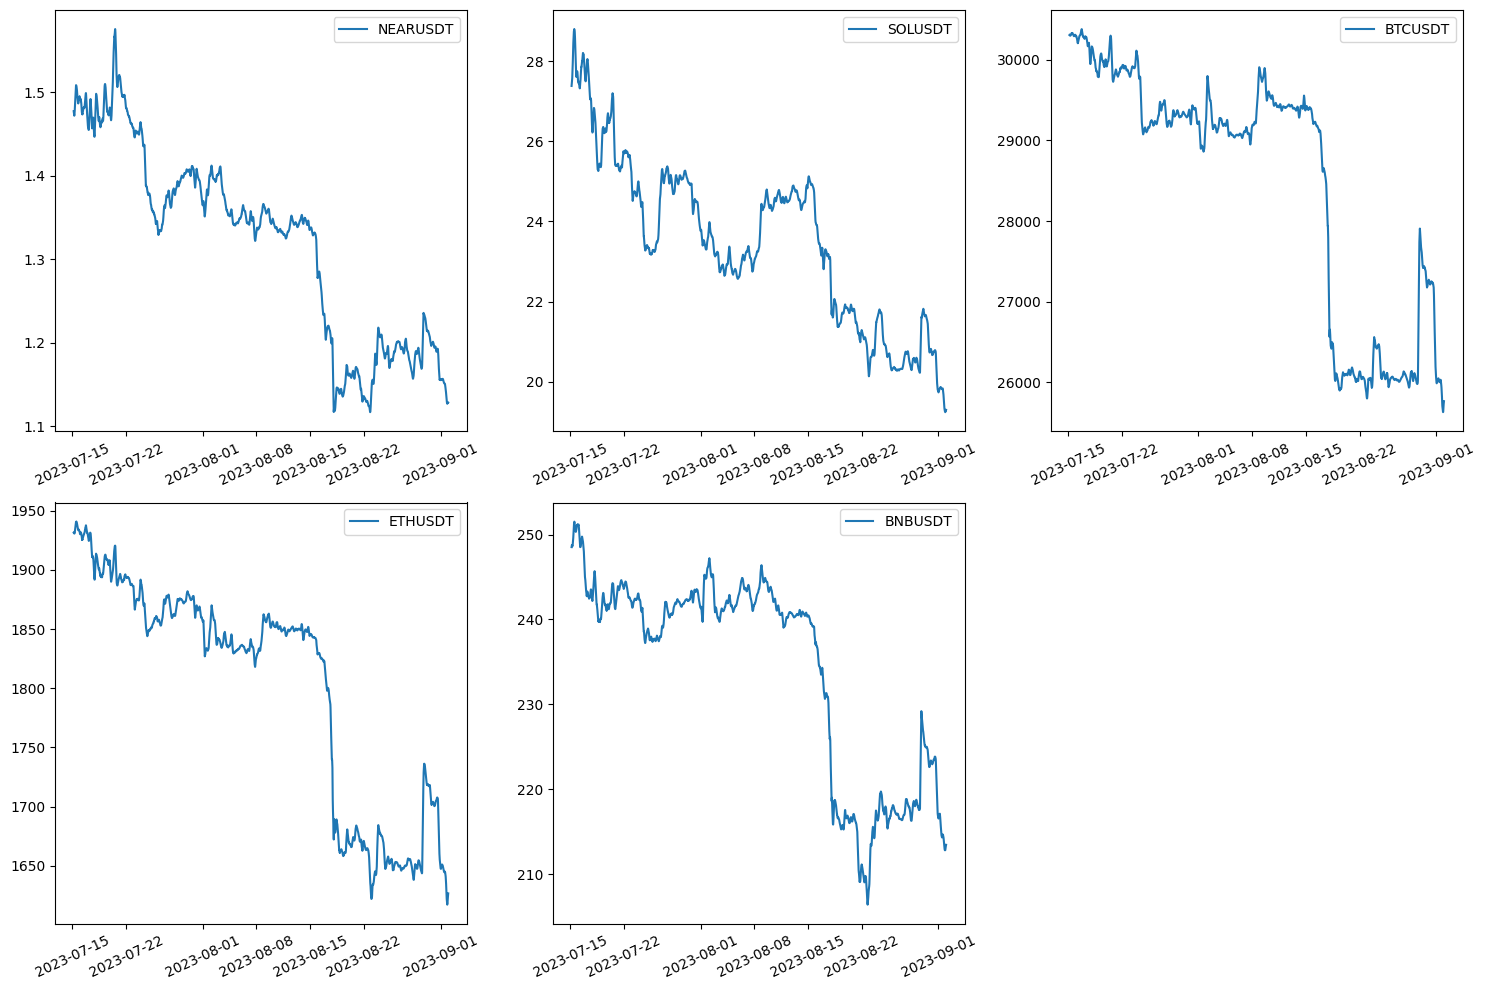

In [34]:
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

# Number of rows and columns for the subplot grid
nrows, ncols = 2, 3

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
axs = axs.flatten()  # Flatten the array to easily iterate over it

# Iterate over each DataFrame and its corresponding axis
for (df_scaled, df, scaler, name), ax in zip(df_tickers, axs[:5]):
    start = "2023-07-15"
    end = "2023-09-01"

    y = df.loc[start:end].Close

    y = y.rolling(window=256).mean()
    ax.plot(y, label=name)

    # Set date formatting for x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Rotate date labels for clarity
    for label in ax.get_xticklabels():
        label.set_rotation(25)

    ax.legend()

if len(df_tickers) < 6:
    axs[5].axis('off')

# Adjust the layout
plt.tight_layout()
plt.savefig("prices of different coints from 2023-07-15 to 2023-10-01.png")

In [1]:
from util import load_pickle
import os
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

filenames = next(os.walk(f"backtest-results/"), (None, None, []))[2]  # [] if no file
results = {}
for filename in filenames:
    (trades, equity_curve) = load_pickle(f"backtest-results/{filename}")
    parts = filename.split("_")
    model_name = "_".join(parts[:-1])  # Get all parts except the last one as the model name
    coin = parts[-1].split('.')[0]  # Get the last part as the coin, and remove file extension

    if model_name not in results:
        results[model_name] = []
    results[model_name].append((coin, trades, equity_curve, filename))

buy_hold = "Buy and Hold"
buy_hold_res = results.pop(buy_hold)


Model hs128_lstm1_net[256, 256, 256]_ws128 metrics:
cumulative_return=-0.1978, max_earning_rate=0.0278, maximum_pullback=0.0272, average_profitability_per_trade=-0.1690, sharpe_ratio=-0.0057


Model hs128_lstm1_net[256, 256, 256]_ws32 metrics:
cumulative_return=0.1287, max_earning_rate=0.0220, maximum_pullback=0.0268, average_profitability_per_trade=0.0836, sharpe_ratio=0.0046


Model hs128_lstm1_net[256, 256, 256]_ws64 metrics:
cumulative_return=0.0000, max_earning_rate=0.0000, maximum_pullback=0.0000, average_profitability_per_trade=nan, sharpe_ratio=nan


Model hs128_lstm2_net[256, 256, 256]_ws128 metrics:
cumulative_return=0.0000, max_earning_rate=0.0000, maximum_pullback=0.0000, average_profitability_per_trade=nan, sharpe_ratio=nan


Model hs128_lstm2_net[256, 256, 256]_ws32 metrics:
cumulative_return=0.0000, max_earning_rate=0.0000, maximum_pullback=0.0000, average_profitability_per_trade=nan, sharpe_ratio=nan


Model hs128_lstm2_net[256, 256, 256]_ws64 metrics:
cumulative_retur

/mnt/storage/dima/Doc/Documents/Особисте/Проєкти/Projects/price_prediction_experiment/trading_metrics.py:34: RuntimeWarning: invalid value encountered in scalar divide
  return ((P_end - P_0) / P_0) / NT * 100
/mnt/storage/dima/Doc/Documents/Особисте/Проєкти/Projects/price_prediction_experiment/trading_metrics.py:46: RuntimeWarning: invalid value encountered in scalar divide
  return (E_Rp - R_f) / sigma_P



Model hs256_lstm1_net[256, 256, 256]_ws128 metrics:
cumulative_return=0.1004, max_earning_rate=0.0248, maximum_pullback=0.0271, average_profitability_per_trade=0.0196, sharpe_ratio=0.0031


Model hs256_lstm1_net[256, 256, 256]_ws32 metrics:
cumulative_return=0.0000, max_earning_rate=0.0000, maximum_pullback=0.0000, average_profitability_per_trade=nan, sharpe_ratio=nan


Model hs256_lstm1_net[256, 256, 256]_ws64 metrics:
cumulative_return=0.1263, max_earning_rate=0.0264, maximum_pullback=0.0301, average_profitability_per_trade=0.0320, sharpe_ratio=0.0041


Model hs256_lstm2_net[256, 256, 256]_ws128 metrics:
cumulative_return=-0.2629, max_earning_rate=0.0285, maximum_pullback=0.0273, average_profitability_per_trade=-0.1765, sharpe_ratio=-0.0080


Model hs256_lstm2_net[256, 256, 256]_ws32 metrics:
cumulative_return=0.1238, max_earning_rate=0.0259, maximum_pullback=0.0232, average_profitability_per_trade=0.0760, sharpe_ratio=0.0047


Model hs256_lstm2_net[256, 256, 256]_ws64 metrics:
cumu

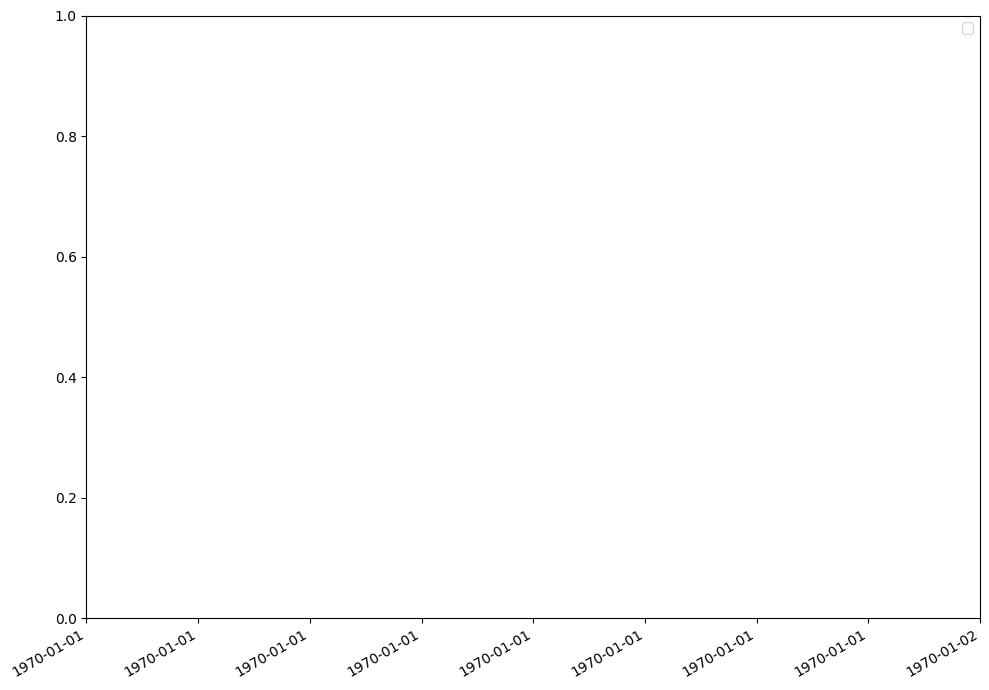

In [2]:
from trading_metrics import calculate_metrics
import re


def plot_equity(model_name, model_equities):
    match = re.search("ws(\d+)", model_name)
    in_obs = int(match.group(1)) if match else 64
    skip_steps = 1024 + in_obs

    sum_equity = None
    equities = model_equities
    for item in equities:
        if sum_equity is None:
            sum_equity = item[2]["Equity"].iloc[skip_steps:].copy()
        else:
            sum_equity += item[2]["Equity"].iloc[skip_steps:]

    start_cash = 1_000_000
    tickers_count = 5
    trades_count = sum(map(lambda x: len(x[1]), equities))
    metrics = calculate_metrics(sum_equity, trades_count, start_cash * tickers_count)

    sum_equity = sum_equity.rolling(window=256).mean()[256:]

    y = (sum_equity - start_cash * tickers_count) / (start_cash * tickers_count)

    choice = i % 6
    if choice == 0:
        plt.plot(y, '-v', markevery=1024, label=model_name)
    elif choice == 1:
        plt.plot(y, '-x', markevery=1024, label=model_name)
    elif choice == 2:
        plt.plot(y, '-o', markevery=1024, label=model_name)
    elif choice == 3:
        plt.plot(y, '--+', markevery=1024, label=model_name)
    elif choice == 4:
        plt.plot(y, '--*', markevery=1024, label=model_name)
    elif choice == 5:
        plt.plot(y, markevery=1024, label=model_name)

    print()
    print(f"{model_name} metrics:")
    print(f"cumulative_return={metrics[0]:.4f}, "
          f"max_earning_rate={metrics[1]:.4f}, "
          f"maximum_pullback={metrics[2]:.4f}, "
          f"average_profitability_per_trade={metrics[3]:.4f}, "
          f"sharpe_ratio={metrics[4]:.4f}")
    print()


plt.figure(figsize=(10, 7))

i = 0
for model in sorted(list(results.keys())):
    plot_equity(model, results[model])

    if i % 6 == 5:
        plot_equity(buy_hold, buy_hold_res)

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gcf().autofmt_xdate()
        plt.legend()
        plt.tight_layout()

        # plt.show()
        plt.savefig(f"backtest_graphs/equity{i // 6 + 1}")
        plt.cla()
    i += 1

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()

# plt.show()
plt.savefig(f"backtest_graphs/equity{i // 6 + 1}")